## Survival prediction using somatic mutation data

In this notebook, we'll compare the results of survival prediction using [elastic net Cox regression](https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.linear_model.CoxnetSurvivalAnalysis.html) for expression and methylation data only.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.survival_utilities as su
import mpmp.utilities.plot_utilities as plu

%load_ext autoreload
%autoreload 2

### Parameters and data directories

In [2]:
# set results directories
# TODO: document why these need to be different
pancan_results_dir = Path(cfg.results_dirs['survival'], 'mutations_me_all')
cancer_type_results_dir = Path(cfg.results_dirs['survival'], 'mutations_me_cancer_type')

# set list of PCA component numbers to look for
n_pcs = 10

### Pan-cancer survival prediction, expression vs. methylation

These are models trained and tested on all data types in TCGA, for all samples that have expression and DNA methylation data profiled. We compare against a clinical covariate-only baseline (grey dotted line).

In [3]:
# order to plot data types in
training_data_map = {
    'expression': 'gene expression',
    'me_27k': '27k methylation',
    'me_450k': '450k methylation',
    'vogelstein_mutations': 'all Vogelstein mutations',
    'significant_mutations': 'significant mutations',
    'mutation_preds_expression': 'mutation scores, expression',
    'mutation_preds_me_27k': 'mutation scores, 27k',
    'mutation_preds_me_450k': 'mutation scores, 450k',
}

In [4]:
pancan_results_df = su.load_survival_results(pancan_results_dir)
pancan_results_df.rename(columns={'identifier': 'cancer_type',
                                  'fold_no': 'fold'}, inplace=True)
pancan_results_df = pancan_results_df[(pancan_results_df.cancer_type == 'pancancer') |
                                      (~pancan_results_df.training_data.str.startswith('mutation_preds'))]
                                      
pancan_results_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(pancan_results_df.shape)
print(pancan_results_df.cancer_type.unique())
print(pancan_results_df.training_data.unique())
pancan_results_df.head()

(9216, 7)
['THCA' 'PCPG' 'ACC' 'LIHC' 'SARC' 'SKCM' 'pancancer' 'UCEC' 'LUSC' 'COAD'
 'STAD' 'TGCT' 'LUAD' 'KIRP' 'BRCA' 'GBM' 'HNSC' 'THYM' 'READ' 'ESCA'
 'LGG' 'UCS' 'KIRC' 'UVM' 'BLCA' 'LAML' 'PAAD' 'KICH' 'MESO' 'CHOL' 'PRAD'
 'CESC' 'DLBC']
['baseline' 'gene expression' '450k methylation'
 'all Vogelstein mutations' '27k methylation' 'significant mutations'
 'mutation scores, 450k' 'mutation scores, 27k'
 'mutation scores, expression']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58665,train,THCA,baseline,shuffled,42,0
1,0.58665,cv,THCA,baseline,shuffled,42,0
2,0.64457,test,THCA,baseline,shuffled,42,0
3,0.51805,train,THCA,baseline,shuffled,42,1
4,0.51805,cv,THCA,baseline,shuffled,42,1


In [5]:
cancer_type_results_df = su.load_survival_results(cancer_type_results_dir)
cancer_type_results_df.rename(columns={'identifier': 'cancer_type',
                                       'fold_no': 'fold'}, inplace=True)
cancer_type_results_df.training_data.replace(to_replace=training_data_map, inplace=True)

print(cancer_type_results_df.shape)
print(cancer_type_results_df.cancer_type.unique())
print(len(cancer_type_results_df.cancer_type.unique()))
print(cancer_type_results_df.training_data.unique())
cancer_type_results_df.head()

(4284, 7)
['HNSC' 'UCS' 'UVM' 'MESO' 'PCPG' 'STAD' 'TGCT' 'ACC' 'GBM' 'KIRP' 'LGG'
 'ESCA' 'KICH' 'READ' 'LIHC' 'LUAD' 'BRCA' 'THCA' 'BLCA' 'PAAD' 'COAD'
 'PRAD' 'SKCM' 'LUSC' 'THYM' 'CESC' 'SARC' 'UCEC' 'LAML' 'KIRC' 'DLBC']
31
['mutation scores, 450k' 'mutation scores, expression'
 'mutation scores, 27k']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.71664,train,HNSC,"mutation scores, 450k",signal,42,0
1,0.71664,cv,HNSC,"mutation scores, 450k",signal,42,0
2,0.55399,test,HNSC,"mutation scores, 450k",signal,42,0
3,0.71748,train,HNSC,"mutation scores, 450k",signal,42,1
4,0.71748,cv,HNSC,"mutation scores, 450k",signal,42,1


In [6]:
results_df = pd.concat((pancan_results_df, cancer_type_results_df))

print(results_df.shape)
print(results_df.cancer_type.unique())
print(len(results_df.cancer_type.unique()))
print(results_df.training_data.unique())
results_df.head()

(13500, 7)
['THCA' 'PCPG' 'ACC' 'LIHC' 'SARC' 'SKCM' 'pancancer' 'UCEC' 'LUSC' 'COAD'
 'STAD' 'TGCT' 'LUAD' 'KIRP' 'BRCA' 'GBM' 'HNSC' 'THYM' 'READ' 'ESCA'
 'LGG' 'UCS' 'KIRC' 'UVM' 'BLCA' 'LAML' 'PAAD' 'KICH' 'MESO' 'CHOL' 'PRAD'
 'CESC' 'DLBC']
33
['baseline' 'gene expression' '450k methylation'
 'all Vogelstein mutations' '27k methylation' 'significant mutations'
 'mutation scores, 450k' 'mutation scores, 27k'
 'mutation scores, expression']


,cindex,data_type,cancer_type,training_data,signal,seed,fold
0,0.58665,train,THCA,baseline,shuffled,42,0
1,0.58665,cv,THCA,baseline,shuffled,42,0
2,0.64457,test,THCA,baseline,shuffled,42,0
3,0.51805,train,THCA,baseline,shuffled,42,1
4,0.51805,cv,THCA,baseline,shuffled,42,1


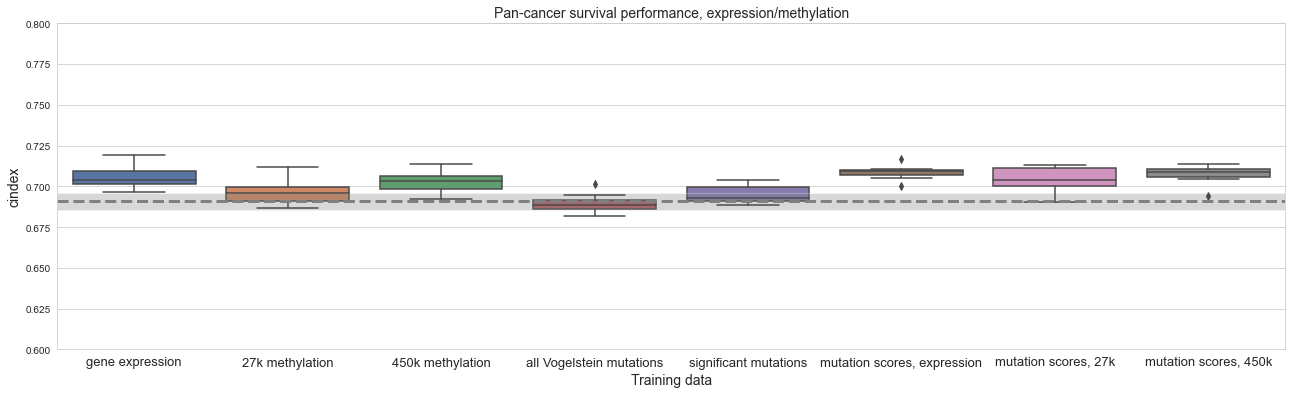

In [7]:
sns.set({'figure.figsize': (22, 6)})
sns.set_style('whitegrid')

plot_df = results_df[(results_df.training_data != 'baseline') &
                     (results_df.cancer_type == 'pancancer') &
                     (results_df.data_type == 'test') &
                     (results_df.signal == 'signal')]
sns.boxplot(data=plot_df, x='training_data', y='cindex',
            order=training_data_map.values())
plt.xlabel('Training data', size=14)
plt.ylabel('cindex', size=14)
plt.title('Pan-cancer survival performance, expression/methylation', size=14)
plt.ylim(0.6, 0.8)
for tick in plt.gca().get_xticklabels():
    tick.set_fontsize(13)

# plot baseline mean/bootstrapped 95% CI
baseline_df = results_df[(results_df.training_data == 'baseline') &
                         (results_df.cancer_type == 'pancancer') &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
baseline_vals = baseline_df.cindex.values

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

### Individual cancer survival prediction, expression vs. methylation

These are models trained and tested on each individual data type in TCGA, for all samples that have expression and DNA methylation data profiled. Like before, grey dotted lines are clinical covariate-only baselines, for that specific cancer type.

We only ran these experiments using 10 principal components extracted from the -omics datasets, since using more PCs than that led to convergence issues on many cancer types.

In [8]:
group_cancer_types = results_df.groupby(['cancer_type']).count().seed
max_count = group_cancer_types.max()
valid_cancer_types = group_cancer_types[group_cancer_types == max_count].index
print(len(valid_cancer_types))
print(valid_cancer_types)
print(group_cancer_types)

30
Index(['ACC', 'BLCA', 'BRCA', 'CESC', 'COAD', 'ESCA', 'GBM', 'HNSC', 'KIRC',
       'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'MESO', 'PAAD', 'PCPG',
       'PRAD', 'READ', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC',
       'UCS', 'UVM', 'pancancer'],
      dtype='object', name='cancer_type')
cancer_type
ACC          432
BLCA         432
BRCA         432
CESC         432
CHOL         216
COAD         432
DLBC         108
ESCA         432
GBM          432
HNSC         432
KICH         216
KIRC         432
KIRP         432
LAML         432
LGG          432
LIHC         432
LUAD         432
LUSC         432
MESO         432
PAAD         432
PCPG         432
PRAD         432
READ         432
SARC         432
SKCM         432
STAD         432
TGCT         432
THCA         432
THYM         432
UCEC         432
UCS          432
UVM          432
pancancer    432
Name: seed, dtype: int64


In [9]:
cancer_type_avg = (
    results_df[(results_df.cancer_type.isin(valid_cancer_types)) &
               (results_df.data_type == 'test') &
               (results_df.signal == 'signal')]
      .groupby('cancer_type')
      .mean()
).cindex
cancer_type_avg.sort_values(ascending=False).head(10)

cancer_type
ACC          0.769226
pancancer    0.699964
LGG          0.696951
UVM          0.675465
KIRP         0.671715
LAML         0.658049
KIRC         0.644100
SARC         0.630669
SKCM         0.622436
MESO         0.618072
Name: cindex, dtype: float64

In [10]:
cancer_type_sd = (
    results_df[(results_df.cancer_type.isin(valid_cancer_types)) &
               (results_df.data_type == 'test') &
               (results_df.signal == 'signal')]
      .groupby('cancer_type')
      .std()
).cindex
cancer_type_cv = cancer_type_avg / cancer_type_sd
cancer_type_cv.sort_values(ascending=False).head(10)

cancer_type
pancancer    73.934911
LGG          17.654438
HNSC         11.782626
SKCM         11.743599
BLCA         11.217978
LAML         10.446719
LUSC         10.109132
ACC          10.078360
SARC          9.944840
KIRC          9.164322
Name: cindex, dtype: float64

In [11]:
import mpmp.utilities.data_utilities as du
sample_info_df = du.load_sample_info('expression')
top_sampled_cancer_types = sample_info_df.groupby('cancer_type').count().sample_type.sort_values(ascending=False).index

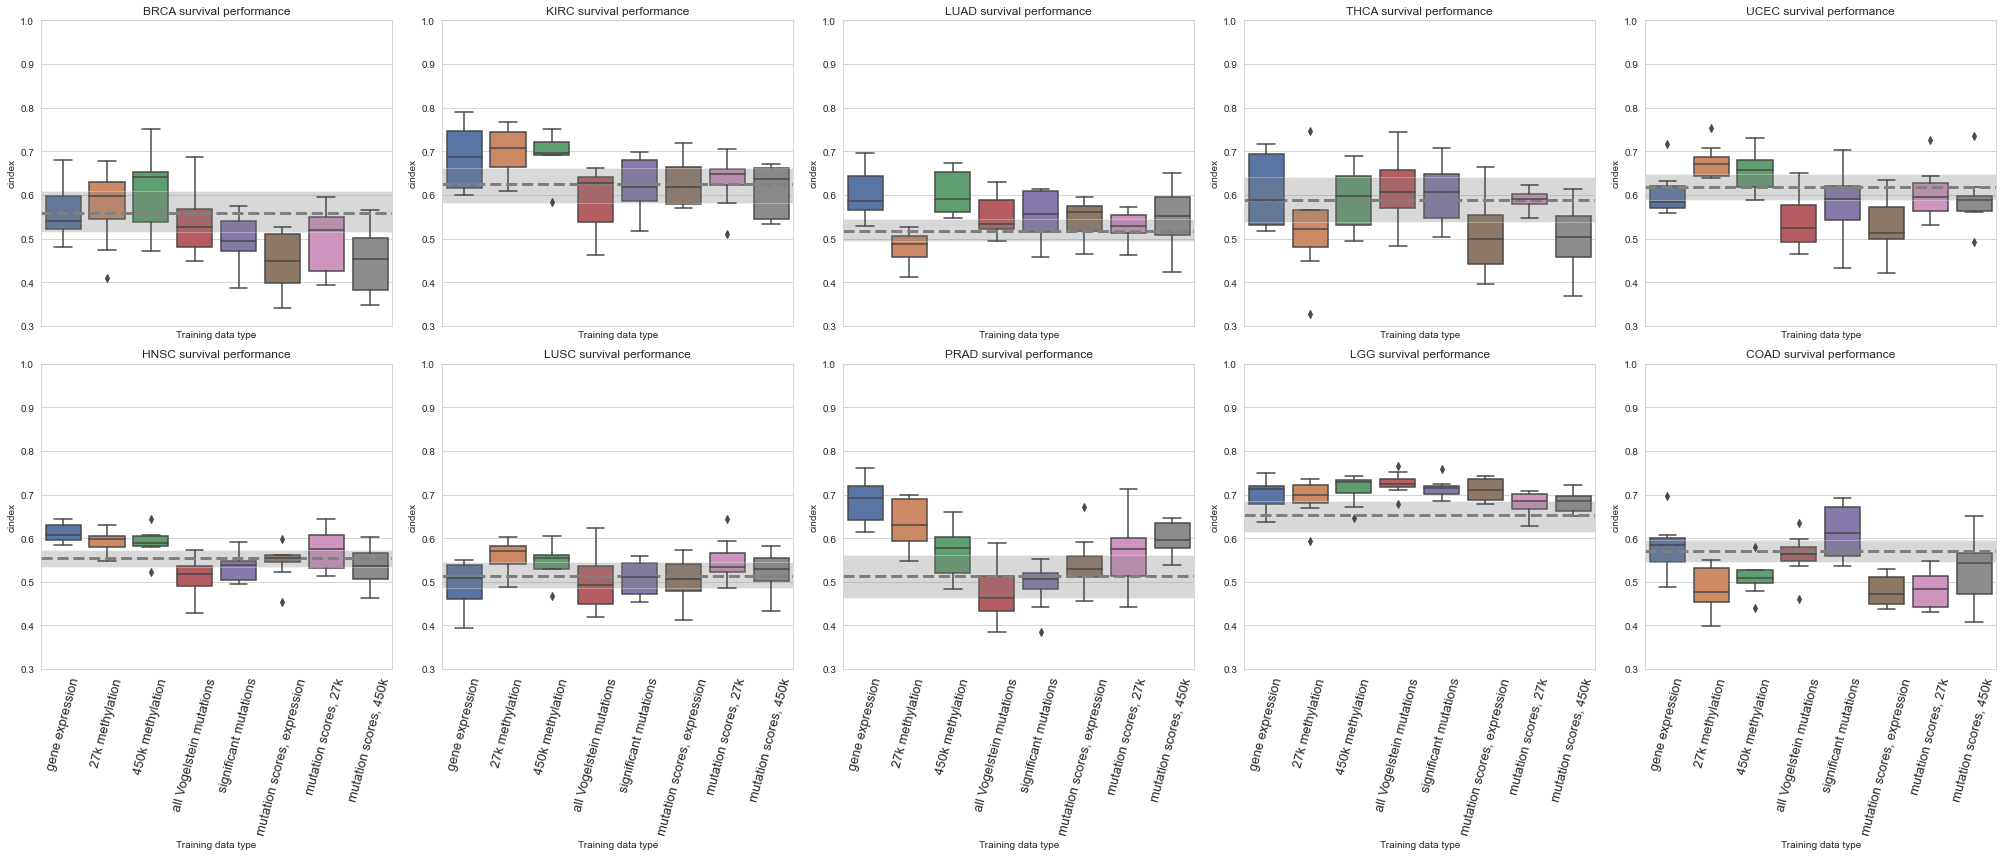

In [12]:
# sns.set({'figure.figsize': (28, 20)})
sns.set({'figure.figsize': (28, 12)})
sns.set_style('whitegrid')
# fig, axarr = plt.subplots(6, 5)
fig, axarr = plt.subplots(2, 5)

cancer_type_cv = cancer_type_cv[cancer_type_cv.index != 'pancancer']
# for ix, cancer_type in enumerate(cancer_type_cv.sort_values(ascending=False).index[:10]):
# for ix, cancer_type in enumerate(valid_cancer_types):
for ix, cancer_type in enumerate(top_sampled_cancer_types[:10]):
    ax = axarr[ix // 5, ix % 5]
    plot_df = results_df[(results_df.training_data != 'baseline') &
                         (results_df.cancer_type == cancer_type) &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
    sns.boxplot(data=plot_df, x='training_data', y='cindex',
                order=training_data_map.values(), ax=ax)
    ax.set_xlabel('Training data type')
    ax.set_ylabel('cindex')
    ax.set_title('{} survival performance'.format(cancer_type))
    ax.set_ylim(0.3, 1.0)
    if (ix // 5) == 1:
        for tick in ax.get_xticklabels():
            tick.set_rotation(75)
            tick.set_fontsize(13)
    else:
        ax.set_xticks([])
        
    # plot baseline mean/bootstrapped 95% CI
    baseline_vals = (results_df
        [(results_df.training_data == 'baseline') &
         (results_df.cancer_type == cancer_type) &
         (results_df.data_type == 'test') &
         (results_df.signal == 'signal')]
    ).cindex.values

    baseline_mean = np.mean(baseline_vals)
    ax.axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

    baseline_ci = sns.utils.ci(
        sns.algorithms.bootstrap(baseline_vals,
                                 func=np.mean,
                                 n_boot=1000,
                                 units=None,
                                 seed=cfg.default_seed)
    )
    ax.axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)
    
plt.tight_layout()

Text(0.5, 1.0, 'Performance for varying PC count, averaged over cancer types')

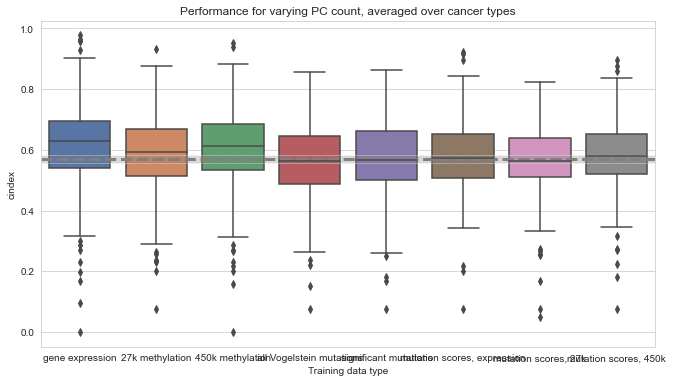

In [13]:
sns.set({'figure.figsize': (11, 6)})
sns.set_style('whitegrid')

plot_df = results_df[(results_df.training_data != 'baseline') &
                     (results_df.data_type == 'test') &
                     (results_df.signal == 'signal')]
sns.boxplot(data=plot_df, x='training_data', y='cindex',
            order=training_data_map.values())

# plot baseline mean/bootstrapped 95% CI
baseline_df = results_df[(results_df.training_data == 'baseline') &
                         (results_df.data_type == 'test') &
                         (results_df.signal == 'signal')]
baseline_vals = baseline_df.cindex.values

baseline_mean = np.mean(baseline_vals)
plt.gca().axhline(y=baseline_mean, linestyle='--', linewidth=3, color='gray')

baseline_ci = sns.utils.ci(
    sns.algorithms.bootstrap(baseline_vals,
                             func=np.mean,
                             n_boot=1000,
                             units=None,
                             seed=cfg.default_seed)
)
plt.gca().axhspan(baseline_ci[0], baseline_ci[1], facecolor='gray', alpha=0.3)

plt.xlabel('Training data type')
plt.ylabel('cindex')
plt.title('Performance for varying PC count, averaged over cancer types')